In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import random

# Define the PyTorch Dataset
class DrivingDataset(Dataset):
    def __init__(self, data_file, root_dir, transform=None):
        with open(data_file) as f:
            self.data = f.readlines()
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        line = self.data[idx].split()
        fff = line[1]
        y_lab = fff.split(',')[0]
        img_name = os.path.join(self.root_dir, line[0])
        image = Image.open(img_name)
        steering_angle = float(y_lab) * np.pi / 180

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'steering_angle': torch.tensor(steering_angle)}

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolution layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=1152, out_features=1164),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1164, out_features=100),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=100, out_features=50),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = Net()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)

# Dataset and DataLoader
transform = transforms.Compose([transforms.Resize((66, 200)),
                                transforms.ToTensor(),])

dataset = DrivingDataset(data_file='/kaggle/input/ai4cps/07012018/data.txt',
                         root_dir='/kaggle/input/ai4cps/07012018/data',
                         transform=transform)

# Splitting the dataset into training and validation sets
num_train = int(len(dataset) * 0.8)
indices = list(range(len(dataset)))
random.shuffle(indices)
train_indices, val_indices = indices[:num_train], indices[num_train:]

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=100, shuffle=False)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

training_losses = []
testing_losses = []
init_val_loss = float('inf')

# Training loop
for epoch in range(35):
    model.train()
    train_running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch}')
    for batch_idx, data in progress_bar:
        # Get data to cuda if possible
        inputs = data['image'].float()
        inputs = inputs.to(device)
        targets = data['steering_angle'].float().unsqueeze(1)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    
    # Print epoch loss
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_running_loss / len(train_loader)))
    training_losses.append(train_running_loss / len(train_loader))

    # Validation step
    model.eval()
    with torch.no_grad():  # No gradients required for validation
        val_running_loss = 0.0
        progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Validation Epoch {epoch}')
        for batch_idx, val_data in progress_bar_val:
            val_inputs = val_data['image'].float().to(device)
            val_targets = val_data['steering_angle'].float().unsqueeze(1).to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        print(f'Validation Loss after epoch {epoch}: {avg_val_loss:.4f}')
        testing_losses.append(avg_val_loss)
        if avg_val_loss < init_val_loss:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_running_loss / len(train_loader),
            }
            torch.save(checkpoint, f'model_epoch_{epoch}.pth')


Epoch 0: 100%|██████████| 511/511 [02:49<00:00,  3.02it/s]


Epoch: 0 Average loss: 0.2162


Validation Epoch 0: 100%|██████████| 128/128 [00:40<00:00,  3.16it/s]


Validation Loss after epoch 0: 0.2216


Epoch 1: 100%|██████████| 511/511 [02:47<00:00,  3.05it/s]


Epoch: 1 Average loss: 0.2143


Validation Epoch 1: 100%|██████████| 128/128 [00:40<00:00,  3.15it/s]


Validation Loss after epoch 1: 0.2204


Epoch 2: 100%|██████████| 511/511 [02:49<00:00,  3.01it/s]


Epoch: 2 Average loss: 0.2122


Validation Epoch 2: 100%|██████████| 128/128 [00:40<00:00,  3.14it/s]


Validation Loss after epoch 2: 0.2169


Epoch 3: 100%|██████████| 511/511 [02:47<00:00,  3.05it/s]


Epoch: 3 Average loss: 0.2109


Validation Epoch 3: 100%|██████████| 128/128 [00:39<00:00,  3.21it/s]


Validation Loss after epoch 3: 0.2173


Epoch 4: 100%|██████████| 511/511 [02:50<00:00,  3.01it/s]


Epoch: 4 Average loss: 0.2076


Validation Epoch 4: 100%|██████████| 128/128 [00:40<00:00,  3.15it/s]


Validation Loss after epoch 4: 0.2088


Epoch 5: 100%|██████████| 511/511 [02:48<00:00,  3.03it/s]


Epoch: 5 Average loss: 0.2035


Validation Epoch 5: 100%|██████████| 128/128 [00:40<00:00,  3.13it/s]


Validation Loss after epoch 5: 0.2020


Epoch 6: 100%|██████████| 511/511 [02:49<00:00,  3.02it/s]


Epoch: 6 Average loss: 0.1975


Validation Epoch 6: 100%|██████████| 128/128 [00:39<00:00,  3.24it/s]


Validation Loss after epoch 6: 0.1971


Epoch 7: 100%|██████████| 511/511 [02:47<00:00,  3.04it/s]


Epoch: 7 Average loss: 0.1921


Validation Epoch 7: 100%|██████████| 128/128 [00:40<00:00,  3.16it/s]


Validation Loss after epoch 7: 0.1883


Epoch 8: 100%|██████████| 511/511 [02:55<00:00,  2.92it/s]


Epoch: 8 Average loss: 0.1876


Validation Epoch 8: 100%|██████████| 128/128 [00:42<00:00,  3.01it/s]


Validation Loss after epoch 8: 0.1858


Epoch 9: 100%|██████████| 511/511 [02:52<00:00,  2.96it/s]


Epoch: 9 Average loss: 0.1840


Validation Epoch 9: 100%|██████████| 128/128 [00:40<00:00,  3.20it/s]


Validation Loss after epoch 9: 0.1747


Epoch 10: 100%|██████████| 511/511 [02:46<00:00,  3.06it/s]


Epoch: 10 Average loss: 0.1784


Validation Epoch 10: 100%|██████████| 128/128 [00:40<00:00,  3.14it/s]


Validation Loss after epoch 10: 0.1736


Epoch 11: 100%|██████████| 511/511 [02:47<00:00,  3.05it/s]


Epoch: 11 Average loss: 0.1750


Validation Epoch 11: 100%|██████████| 128/128 [00:39<00:00,  3.23it/s]


Validation Loss after epoch 11: 0.1636


Epoch 12: 100%|██████████| 511/511 [02:49<00:00,  3.02it/s]


Epoch: 12 Average loss: 0.1699


Validation Epoch 12: 100%|██████████| 128/128 [00:40<00:00,  3.13it/s]


Validation Loss after epoch 12: 0.1574


Epoch 13: 100%|██████████| 511/511 [02:48<00:00,  3.04it/s]


Epoch: 13 Average loss: 0.1662


Validation Epoch 13: 100%|██████████| 128/128 [00:41<00:00,  3.11it/s]


Validation Loss after epoch 13: 0.1562


Epoch 14: 100%|██████████| 511/511 [02:52<00:00,  2.96it/s]


Epoch: 14 Average loss: 0.1565


Validation Epoch 14: 100%|██████████| 128/128 [00:41<00:00,  3.11it/s]


Validation Loss after epoch 14: 0.1424


Epoch 15: 100%|██████████| 511/511 [02:47<00:00,  3.06it/s]


Epoch: 15 Average loss: 0.1504


Validation Epoch 15: 100%|██████████| 128/128 [00:39<00:00,  3.20it/s]


Validation Loss after epoch 15: 0.1350


Epoch 16: 100%|██████████| 511/511 [02:51<00:00,  2.97it/s]


Epoch: 16 Average loss: 0.1455


Validation Epoch 16: 100%|██████████| 128/128 [00:41<00:00,  3.07it/s]


Validation Loss after epoch 16: 0.1311


Epoch 17: 100%|██████████| 511/511 [02:51<00:00,  2.97it/s]


Epoch: 17 Average loss: 0.1370


Validation Epoch 17: 100%|██████████| 128/128 [00:40<00:00,  3.20it/s]


Validation Loss after epoch 17: 0.1202


Epoch 18: 100%|██████████| 511/511 [02:50<00:00,  2.99it/s]


Epoch: 18 Average loss: 0.1333


Validation Epoch 18: 100%|██████████| 128/128 [00:41<00:00,  3.09it/s]


Validation Loss after epoch 18: 0.1082


Epoch 19: 100%|██████████| 511/511 [02:49<00:00,  3.02it/s]


Epoch: 19 Average loss: 0.1269


Validation Epoch 19: 100%|██████████| 128/128 [00:39<00:00,  3.21it/s]


Validation Loss after epoch 19: 0.1145


Epoch 20: 100%|██████████| 511/511 [02:49<00:00,  3.01it/s]


Epoch: 20 Average loss: 0.1212


Validation Epoch 20: 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]


Validation Loss after epoch 20: 0.1080


Epoch 21: 100%|██████████| 511/511 [02:49<00:00,  3.01it/s]


Epoch: 21 Average loss: 0.1177


Validation Epoch 21: 100%|██████████| 128/128 [00:40<00:00,  3.15it/s]


Validation Loss after epoch 21: 0.1115


Epoch 22: 100%|██████████| 511/511 [02:50<00:00,  3.00it/s]


Epoch: 22 Average loss: 0.1163


Validation Epoch 22: 100%|██████████| 128/128 [00:41<00:00,  3.10it/s]


Validation Loss after epoch 22: 0.0974


Epoch 23: 100%|██████████| 511/511 [02:49<00:00,  3.01it/s]


Epoch: 23 Average loss: 0.1127


Validation Epoch 23: 100%|██████████| 128/128 [00:40<00:00,  3.15it/s]


Validation Loss after epoch 23: 0.0869


Epoch 24: 100%|██████████| 511/511 [02:49<00:00,  3.01it/s]


Epoch: 24 Average loss: 0.1132


Validation Epoch 24: 100%|██████████| 128/128 [00:41<00:00,  3.07it/s]


Validation Loss after epoch 24: 0.0938


Epoch 25: 100%|██████████| 511/511 [02:48<00:00,  3.04it/s]


Epoch: 25 Average loss: 0.1076


Validation Epoch 25: 100%|██████████| 128/128 [00:40<00:00,  3.13it/s]


Validation Loss after epoch 25: 0.0787


Epoch 26: 100%|██████████| 511/511 [02:48<00:00,  3.03it/s]


Epoch: 26 Average loss: 0.1054


Validation Epoch 26: 100%|██████████| 128/128 [00:41<00:00,  3.11it/s]


Validation Loss after epoch 26: 0.0794


Epoch 27: 100%|██████████| 511/511 [02:49<00:00,  3.02it/s]


Epoch: 27 Average loss: 0.1044


Validation Epoch 27: 100%|██████████| 128/128 [00:40<00:00,  3.16it/s]


Validation Loss after epoch 27: 0.0858


Epoch 28: 100%|██████████| 511/511 [02:50<00:00,  2.99it/s]


Epoch: 28 Average loss: 0.1021


Validation Epoch 28: 100%|██████████| 128/128 [00:40<00:00,  3.14it/s]


Validation Loss after epoch 28: 0.0995


Epoch 29: 100%|██████████| 511/511 [02:46<00:00,  3.07it/s]


Epoch: 29 Average loss: 0.1041


Validation Epoch 29: 100%|██████████| 128/128 [00:39<00:00,  3.21it/s]


Validation Loss after epoch 29: 0.0927


Epoch 30: 100%|██████████| 511/511 [02:48<00:00,  3.04it/s]


Epoch: 30 Average loss: 0.1004


Validation Epoch 30: 100%|██████████| 128/128 [00:40<00:00,  3.14it/s]


Validation Loss after epoch 30: 0.0780


Epoch 31: 100%|██████████| 511/511 [02:45<00:00,  3.08it/s]


Epoch: 31 Average loss: 0.0993


Validation Epoch 31: 100%|██████████| 128/128 [00:40<00:00,  3.15it/s]


Validation Loss after epoch 31: 0.0729


Epoch 32: 100%|██████████| 511/511 [02:49<00:00,  3.02it/s]


Epoch: 32 Average loss: 0.0973


Validation Epoch 32: 100%|██████████| 128/128 [00:40<00:00,  3.16it/s]


Validation Loss after epoch 32: 0.0781


Epoch 33: 100%|██████████| 511/511 [02:46<00:00,  3.07it/s]


Epoch: 33 Average loss: 0.0933


Validation Epoch 33: 100%|██████████| 128/128 [00:40<00:00,  3.19it/s]


Validation Loss after epoch 33: 0.0807


Epoch 34: 100%|██████████| 511/511 [02:48<00:00,  3.03it/s]


Epoch: 34 Average loss: 0.0930


Validation Epoch 34: 100%|██████████| 128/128 [00:39<00:00,  3.21it/s]

Validation Loss after epoch 34: 0.0815


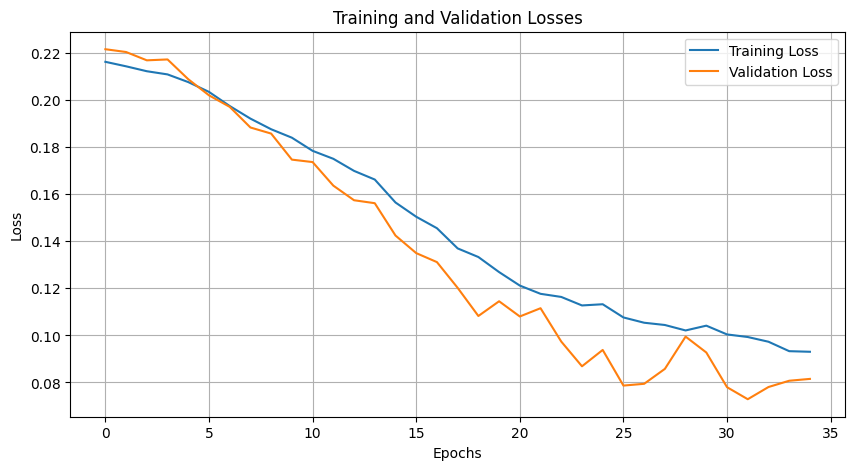

In [4]:
import matplotlib.pyplot as plt

# Plotting the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(testing_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Finding the epoch with the lowest validation loss
min_loss_index = testing_losses.index(min(testing_losses))
checkpoint_path = f'model_epoch_{min_loss_index}.pth'

# Load the best model
model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
print(f"Loaded model from epoch {min_loss_index} with validation loss {min(testing_losses):.4f}")

Loaded model from epoch 31 with validation loss 0.0729


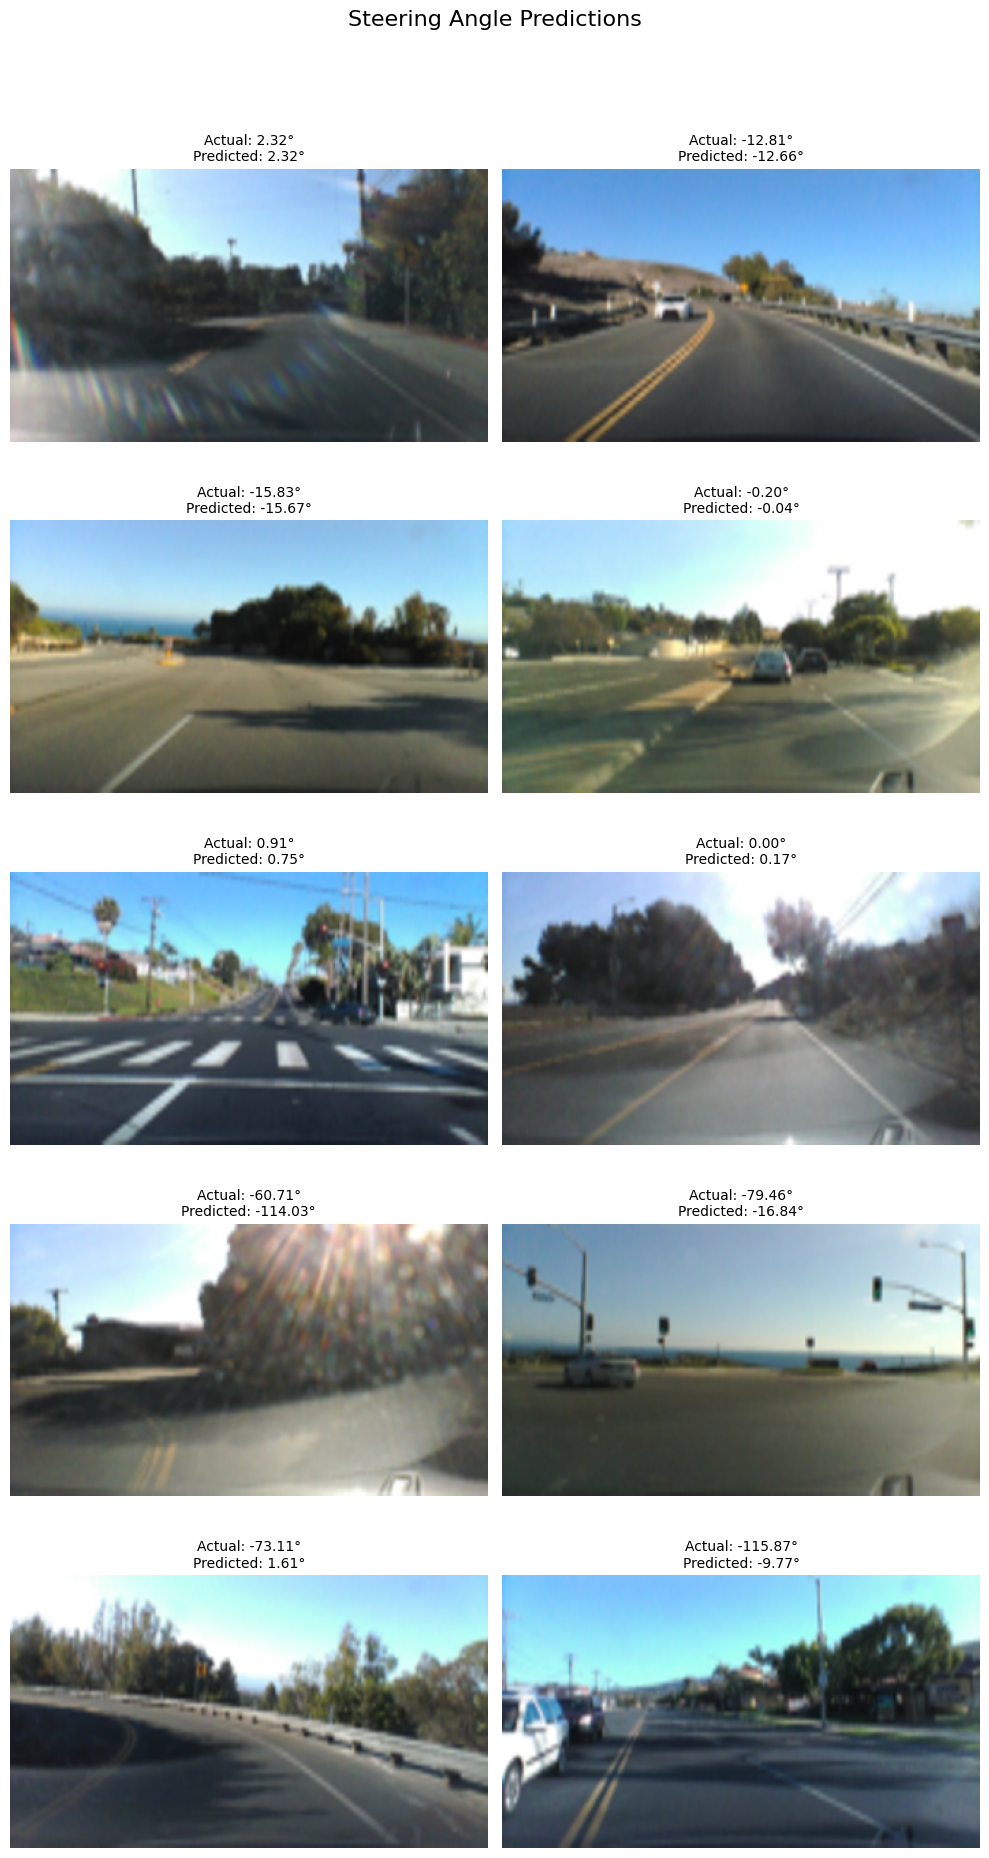

In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def plot_selected_steering_angles(data_loader, model, device, num_good=6, num_bad=4, save_path=None):
    model.eval()
    images, actuals, predictions, errors = [], [], [], []
    
    # Collect data
    with torch.no_grad():
        for data in data_loader:
            inputs = data['image'].float().to(device)
            targets = data['steering_angle'].float().unsqueeze(1).to(device)

            outputs = model(inputs)
            for j in range(inputs.size(0)):  # Loop through batch
                # Resize image for display
                display_image = transforms.functional.to_pil_image(inputs[j].cpu())
                display_image = display_image.resize((350, 200), Image.BICUBIC)
                
                images.append(np.array(display_image))
                actuals.append(targets[j].cpu())
                predictions.append(outputs[j].cpu())
                errors.append(abs(targets[j].item() - outputs[j].item()))

            if len(images) >= num_good + num_bad:  # Collect enough examples
                break

    # Sort by error to select good and bad predictions
    sorted_indices = sorted(range(len(errors)), key=lambda k: errors[k])
    good_indices = sorted_indices[:num_good]
    bad_indices = sorted_indices[-num_bad:]

    # Plot results
    plot_steering_angles_helper(images, actuals, predictions, good_indices + bad_indices, 'Steering Angle Predictions', save_path)

def plot_steering_angles_helper(images, actuals, predictions, indices, title, save_path):
    num_images = len(indices)
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))  # Adjust figure size and grid
    fig.suptitle(title, fontsize=16)
    for idx, ax in zip(indices, axes.flat):
        img = images[idx]  # Use the resized image
        ax.imshow(img)
        actual_angle = actuals[idx].item() * 180 / np.pi  # Convert radians to degrees
        predicted_angle = predictions[idx].item() * 180 / np.pi
        ax.set_title(f"Actual: {actual_angle:.2f}°\nPredicted: {predicted_angle:.2f}°", fontsize=10)
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the figure
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)  # You can adjust the format and dpi
    plt.show()

plot_selected_steering_angles(val_loader, model, device, save_path = 'predictions.png')